In [33]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

%run ./scripts/util_func.py

In [34]:
# import data to dataframe

# data = pd.read_csv("/home/dominic/Documents/publications/sensors2021/offline_model_training/kinematic_models_training/data/data_new.csv") 
data = pd.read_csv("/home/dominic/Documents/publications/sensors2021/offline_model_training/kinematic_models_training/data/data_doughnut1.csv") 

data = data.iloc[36:]

print(data)

       Unnamed: 0      ros_time joy_switch  icp_index  cmd_left_vel  \
36             36  1.606767e+18      False       18.0      0.000000   
37             37  1.606767e+18      False       19.0      0.000000   
38             38  1.606767e+18      False       20.0      0.000000   
39             39  1.606767e+18      False       20.0      0.000000   
40             40  1.606767e+18      False       21.0      0.000000   
...           ...           ...        ...        ...           ...   
43189       43189  1.606769e+18      False    21250.0     23.866667   
43190       43190  1.606769e+18      False    21251.0     23.866667   
43191       43191  1.606769e+18      False    21251.0     23.866667   
43192       43192  1.606769e+18      False    21252.0     23.866667   
43193       43193  1.606769e+18      False    21252.0     23.866667   

       meas_left_vel  cmd_right_vel  meas_right_vel  icp_pos_x  icp_pos_y  \
36               0.0       0.000000             0.0   6.986181   6.466

In [35]:
# convert dataframe to numpy array

array = data.to_numpy()
array =np.delete(array,[0],axis=0)

time_arr = array[:,1]
time_arr = (time_arr - time_arr[0]) * 10**(-9)

joy_arr = array[:,2]
joy_arr = joy_arr == 'False'

icp_index_arr = array[:,3]

left_vel_cmd_arr = array[:,4]
left_vel_meas_arr = array[:,5]
right_vel_cmd_arr = array[:,6]
right_vel_meas_arr = array[:,7]

icp_pos_x_arr = array[:,8]
icp_pos_y_arr = array[:,9]

icp_quat_x_arr = array[:,10]
icp_quat_y_arr = array[:,11]
icp_quat_z_arr = array[:,12]
icp_quat_w_arr = array[:,13]

# array = data.to_numpy()
# array =np.delete(array,[0],axis=0)

# time_arr = array[:,1]
# time_arr = (time_arr - time_arr[0]) * 10**(-9)

# # joy_arr = array[:,2]
# icp_index_arr = array[:,2]

# left_vel_cmd_arr = array[:,3]
# left_vel_meas_arr = array[:,4]
# right_vel_cmd_arr = array[:,5]
# right_vel_meas_arr = array[:,6]

# icp_pos_x_arr = array[:,7]
# icp_pos_y_arr = array[:,8]

# icp_quat_x_arr = array[:,9]
# icp_quat_y_arr = array[:,10]
# icp_quat_z_arr = array[:,11]
# icp_quat_w_arr = array[:,12]

print(icp_quat_x_arr)


[-0.0015073974447200509 -0.0015533431017180676 -0.0015533431017180676 ...
 -0.006374517284798866 -0.0064496773282309815 -0.0064496773282309815]


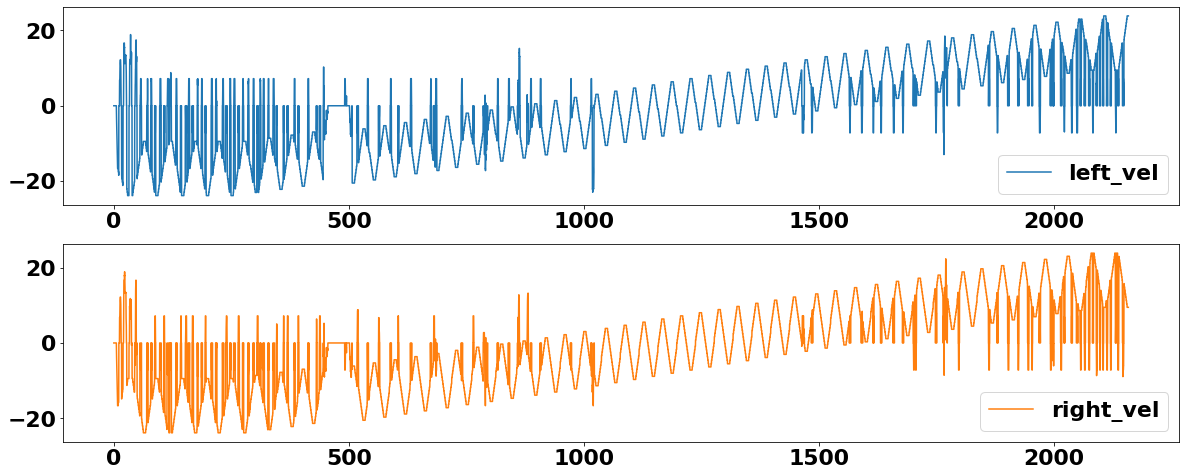

In [36]:
plt.figure(2, figsize=(20,8))
plt.subplot(211)
plt.plot(time_arr, left_vel_cmd_arr, c='tab:blue', label='left_vel')
plt.legend()
plt.subplot(212)
plt.plot(time_arr, right_vel_cmd_arr, c='tab:orange', label='right_vel')
plt.legend()

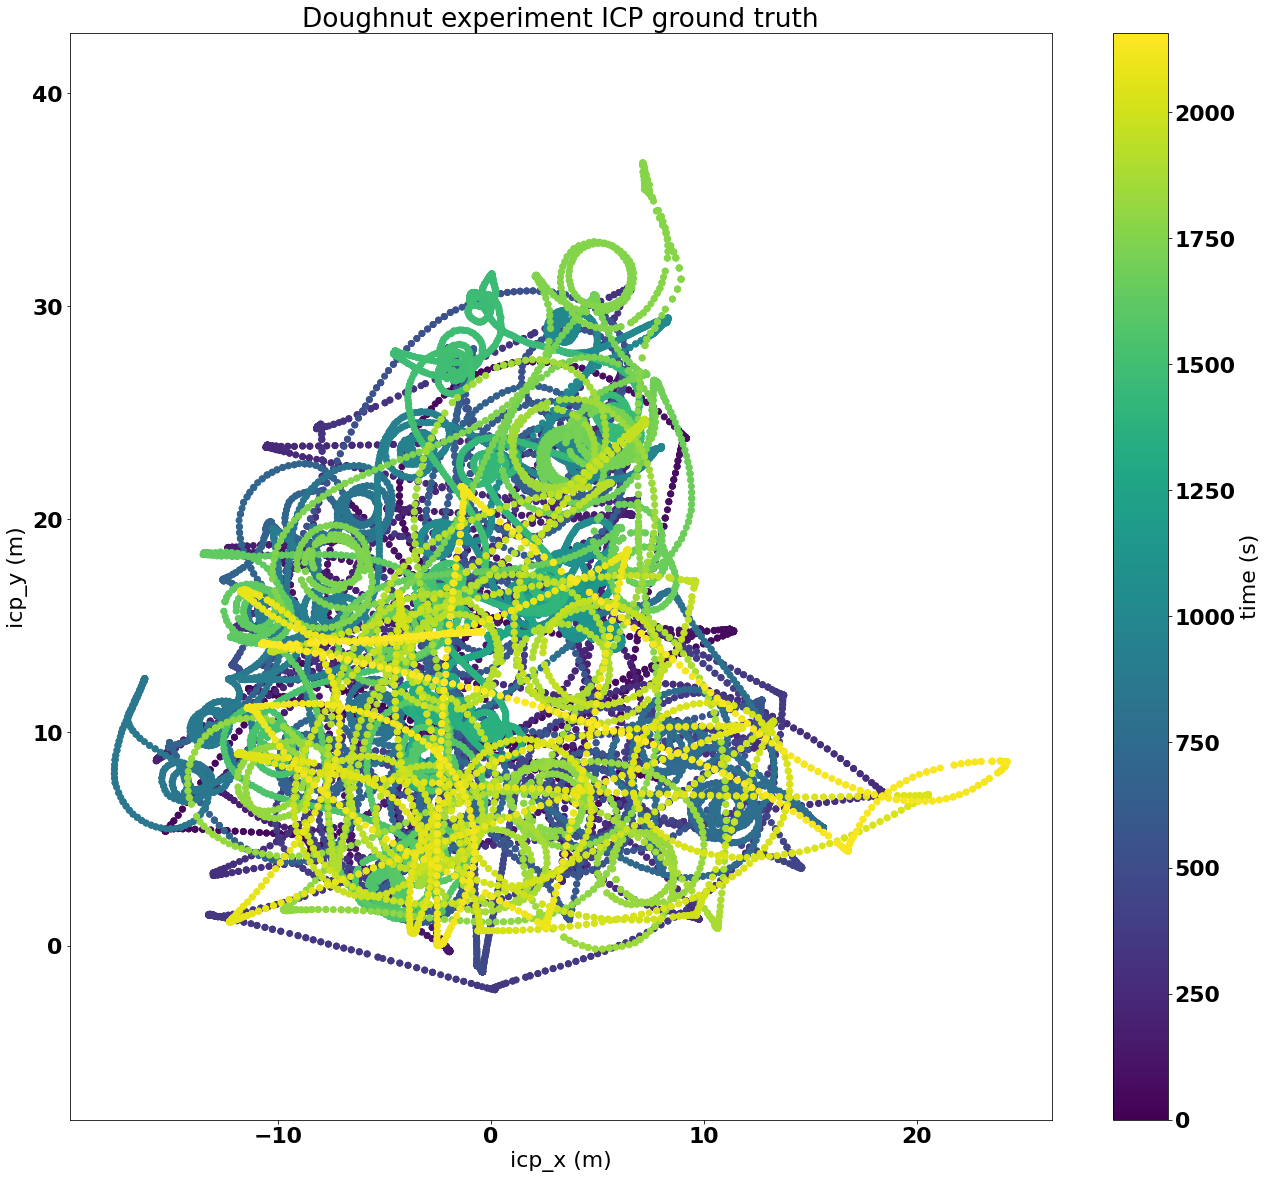

In [37]:
fig = plt.figure(2, figsize = (22,20))
icp = plt.scatter(icp_pos_x_arr, icp_pos_y_arr, c = time_arr)
cb = plt.colorbar(icp)
cb.set_label('time (s)')
plt.axis('equal')
plt.title('Doughnut experiment ICP ground truth')
plt.xlabel('icp_x (m)')
plt.ylabel('icp_y (m)')

fig.savefig('./figs/icp_traj.png')

plt.show()

In [38]:
# Compute Euler Yaw from ICP quaternion

# quat = np.zeros((icp_z_arr.shape[0], 4))
# icp_yaw_arr = np.zeros((icp_z_arr.shape[0], 1))

# for i in range(icp_z_arr.shape[0]):
#     quat[i, 2] = icp_z_arr[i]
#     quat[i, 3] = icp_w_arr[i]
    
#     s_yaw = 2 * np.arcsin(quat[i, 2])
#     c_yaw = 2 * np.arccos(quat[i,3])
#     icp_yaw_arr[i] = np.arctan(s_yaw / c_yaw)
# #     icp_yaw_arr[i] = np.arctan2(np.arcsin2()
    
icp_quat_arr = np.column_stack((icp_quat_x_arr, icp_quat_y_arr, 
                               icp_quat_z_arr, icp_quat_w_arr))    

icp_euler_arr = np.zeros((icp_quat_arr.shape[0], 3))

for i in range(icp_quat_arr.shape[0]):
    icp_euler_arr[i,0], icp_euler_arr[i,1], icp_euler_arr[i,2] = quaternion_to_euler(icp_quat_arr[i,3], icp_quat_arr[i,0], icp_quat_arr[i,1], icp_quat_arr[i,2])

    
print(icp_euler_arr)

[[-0.00140217 -0.00920601 -0.35708207]
 [-0.00145034 -0.00945968 -0.35695938]
 [-0.00145034 -0.00945968 -0.35695938]
 ...
 [-0.01335693 -0.01908499  0.06294949]
 [-0.01350783 -0.01905329  0.06310265]
 [-0.01350783 -0.01905329  0.06310265]]


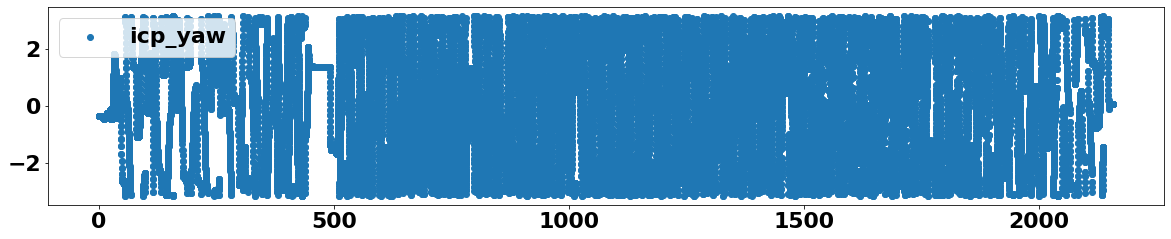

In [39]:
plt.figure(2, figsize=(20,8))
plt.subplot(211)
plt.scatter(time_arr, icp_euler_arr[:,2], c='tab:blue', label='icp_yaw')
plt.legend()

In [40]:
# Built state and input vectors

icp_states = np.column_stack((time_arr, icp_index_arr, icp_pos_x_arr, icp_pos_y_arr, icp_euler_arr[:,2]))

# print(icp_euler_arr[:,2])
# print(icp_states)

wheel_vels = np.column_stack((time_arr, icp_index_arr, left_vel_cmd_arr, right_vel_cmd_arr))

print(wheel_vels)

wheel_vels_meas = np.column_stack((time_arr, icp_index_arr, left_vel_meas_arr, right_vel_meas_arr))

print(wheel_vels_meas)

[[0.0 19.0 0.0 0.0]
 [0.051003648000000006 20.0 0.0 0.0]
 [0.097854464 20.0 0.0 0.0]
 ...
 [2157.70171264 21251.0 23.86666666666667 9.466666666666667]
 [2157.7469585920003 21252.0 23.86666666666667 9.466666666666667]
 [2157.7972864000003 21252.0 23.86666666666667 9.466666666666667]]
[[0.0 19.0 0.0 0.0]
 [0.051003648000000006 20.0 0.0 0.0]
 [0.097854464 20.0 0.0 0.0]
 ...
 [2157.70171264 21251.0 0.0 0.0]
 [2157.7469585920003 21252.0 0.0 0.0]
 [2157.7972864000003 21252.0 0.0 0.0]]


In [41]:
# export data

np.save('data/icp_states_doughnut1.npy', icp_states)
np.save('data/wheel_vels_doughnut1.npy', wheel_vels)
np.save('data/wheel_vels_meas_doughnut1.npy', wheel_vels_meas)


In [42]:
# compute distance traveled

dist_icp = 0

for i in range(time_arr.shape[0] - 1):
    
    dist_icp = dist_icp + comp_disp(icp_states[i+1, 2:], icp_states[i, 2:])
    
print('Distance traveled : ', dist_icp, 'm.')

Distance traveled :  7016.688238981395 m.


In [43]:
# filter joy switch

arr_tot = np.column_stack((icp_states, wheel_vels, wheel_vels_meas))

# bool_mask = np.zeros((arr_tot.shape), dtype=bool)

# for i in range(arr_tot.shape[0]):
#     if arr_tot[i,0]:
#         bool_mask[i,:] = True
#     else:
#         bool_mask[i,:] = False

# print(arr_tot[bool_mask])
arr_tot_no_joy = arr_tot[joy_arr, :]
print(arr_tot_no_joy[0, 9:])


[0.0 19.0 0.0 0.0]


In [44]:
np.save('data/icp_states_nojoy_doughnut1.npy', arr_tot_no_joy[:, :5])
np.save('data/wheel_vels_nojoy_doughnut1.npy', arr_tot_no_joy[:, 5:9])
np.save('data/wheel_vels_meas_nojoy_doughnut1.npy', arr_tot_no_joy[:, 9:])

In [45]:
# create powertrain dynamics wheel velocity estimates

tau_c = 0.35
tau_d = 0.1

pwrtrn_vels = np.zeros(arr_tot_no_joy[:, 5:9].shape)

pwrtrn_vels[:,:2] = arr_tot_no_joy[:, 5:7]

for i in range(1, pwrtrn_vels.shape[0]-1):
    dt = wheel_vels[i,0] - wheel_vels[i-1,0]
    pwrtrn_vels[i+1,2] = powerTrain_vel(tau_c, tau_d, arr_tot_no_joy[:, 7], pwrtrn_vels[:,2], i, dt)
    pwrtrn_vels[i+1,3] = powerTrain_vel(tau_c, tau_d, arr_tot_no_joy[:, 8], pwrtrn_vels[:,3], i, dt)

print(pwrtrn_vels)
print(wheel_vels)

np.save('data/wheel_vels_pwrtrn_nojoy_doughnut1.npy', pwrtrn_vels)

[[0.00000000e+00 1.90000000e+01 0.00000000e+00 0.00000000e+00]
 [5.10036480e-02 2.00000000e+01 0.00000000e+00 0.00000000e+00]
 [9.78544640e-02 2.00000000e+01 0.00000000e+00 0.00000000e+00]
 ...
 [2.15770171e+03 2.12510000e+04 1.30000000e+01 9.46697425e+00]
 [2.15774696e+03 2.12520000e+04 1.30000000e+01 9.46693002e+00]
 [2.15779729e+03 2.12520000e+04 1.30000000e+01 9.46689593e+00]]
[[0.0 19.0 0.0 0.0]
 [0.051003648000000006 20.0 0.0 0.0]
 [0.097854464 20.0 0.0 0.0]
 ...
 [2157.70171264 21251.0 23.86666666666667 9.466666666666667]
 [2157.7469585920003 21252.0 23.86666666666667 9.466666666666667]
 [2157.7972864000003 21252.0 23.86666666666667 9.466666666666667]]


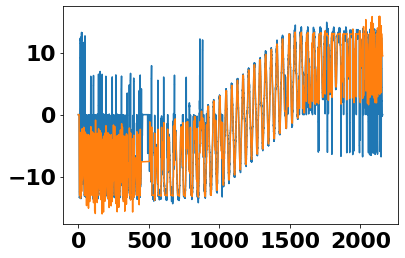

In [14]:
plt.plot(wheel_vels[:,0], wheel_vels_meas[:,3])
plt.plot(pwrtrn_vels[:,0], pwrtrn_vels[:,3])